In [1]:
from explainers.GNNBoundary.gnn_boundary.models.gcn_classifier import GCNClassifier as GCNClassifier
import torch as torch

In [2]:
import numpy as np

In [4]:

model = GCNClassifier(num_layers=3, num_classes=2, node_features=3, hidden_channels=32)
model.load_state_dict(torch.load('model/report_models/house.pt'))

<All keys matched successfully>

In [5]:
from graph_generation.HouseSet import HouseSetCreator
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(HouseSetCreator(10000, 40,60).getDataset())
mean_embeds = dataset.mean_embeddings(model)


[Data(x=[18, 3], edge_index=[2, 10], y=[1])]


In [6]:
y = [data.y for data in dataset]
classes = np.unique(y)
class_indexes = []
for c in classes:
    class_indexes.append(np.where(y == c)[0])
class_indexes

[array([   1,    4,    5, ..., 9992, 9995, 9997]),
 array([   0,    2,    3, ..., 9996, 9998, 9999])]

In [7]:

trainers = {}

In [10]:
from explainers.gnninterpreter import *
c = 0

trainers[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=5,
                num_node_cls=3,
                temperature=0.15,
                learn_node_feat=True
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=5),
                #dict(key="logits", criterion=ClassScoreCriterion(class_idx=, mode='minimize'), weight=5),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=5),
                dict(key="logits", criterion=MeanPenalty(), weight=0),
                dict(key="omega", criterion=NormPenalty(order=1), weight=1),
                dict(key="omega", criterion=NormPenalty(order=2), weight=1),
                dict(key="xi", criterion=NormPenalty(order=1), weight=0),
                dict(key="xi", criterion=NormPenalty(order=2), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=16
        )
trainers[c].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=5 m=8
logits=[-3.07940411567688, 3.4861221313476562]
probs=[0.0014061031397432089, 0.9985938668251038]


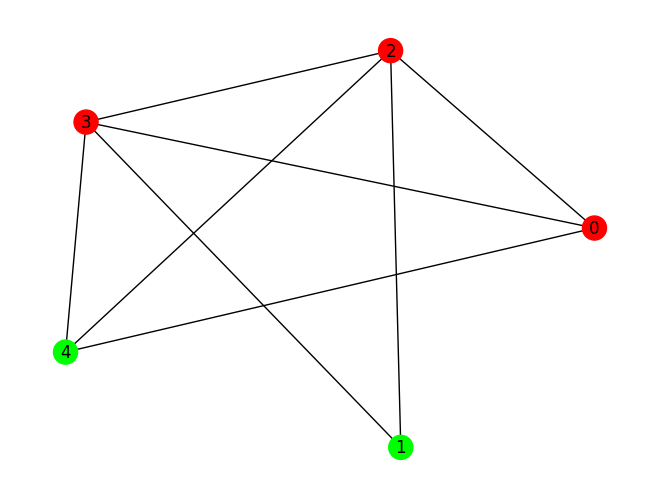

(<networkx.classes.graph.Graph at 0x7fa60e133220>,
 {'n': 5,
  'm': 8,
  'logits': [-3.07940411567688, 3.4861221313476562],
  'probs': [0.0014061031397432089, 0.9985938668251038]})

In [9]:
trainers[1].evaluate(threshold=0.5, show=True)

n=5 m=8
logits=[2.8428707122802734, -2.666126251220703]
probs=[0.9959661960601807, 0.004033830016851425]


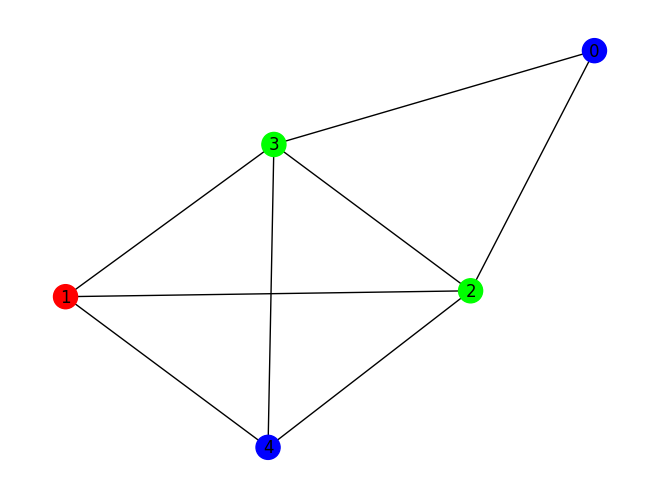

(<networkx.classes.graph.Graph at 0x7fa60e132e90>,
 {'n': 5,
  'm': 8,
  'logits': [2.8428707122802734, -2.666126251220703],
  'probs': [0.9959661960601807, 0.004033830016851425]})

In [11]:
trainers[0].evaluate(threshold=0.5, show=True)